In [21]:
!pip install seaborn

   ---------------------------------------- 0.0/294.6 kB ? eta -:--:--
   -------- ------------------------------- 61.4/294.6 kB 1.1 MB/s eta 0:00:01
   ------------------------------ --------- 225.3/294.6 kB 2.3 MB/s eta 0:00:01
   ---------------------------------------- 294.6/294.6 kB 2.6 MB/s eta 0:00:00


In [22]:
import json, io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [6]:
data_path = "PriceHistory.jsonl"

t = 0
data = []
with open(data_path, "r", encoding = "utf-8") as json_file:
    for line in json_file.readlines():
        t = t+1
        stream = io.StringIO(line)
        parsed = json.load(stream)
        data.append(parsed)

In [8]:
print(data[0:3])

[{'date': '23/11/2023', 'ThayDoi': '-0.55(-2.96 %)', 'GiaDieuChinh': 18.05, 'GiaDongCua': 18.05, 'KhoiLuongKhopLenh': 7224200, 'GiaTriKhopLenh': 133699000000, 'KLThoaThuan': 13550000, 'GtThoaThuan': 240230000000, 'GiaMoCua': 18.65, 'GiaCaoNhat': 18.65, 'GiaThapNhat': 18.05}, {'date': '22/11/2023', 'ThayDoi': '-0.1(-0.53 %)', 'GiaDieuChinh': 18.6, 'GiaDongCua': 18.6, 'KhoiLuongKhopLenh': 6671100, 'GiaTriKhopLenh': 124294000000, 'KLThoaThuan': 237300, 'GtThoaThuan': 4407915000, 'GiaMoCua': 18.75, 'GiaCaoNhat': 18.8, 'GiaThapNhat': 18.45}, {'date': '21/11/2023', 'ThayDoi': '0(0.00 %)', 'GiaDieuChinh': 18.7, 'GiaDongCua': 18.7, 'KhoiLuongKhopLenh': 6718100, 'GiaTriKhopLenh': 125247000000, 'KLThoaThuan': 11610601, 'GtThoaThuan': 203235017500, 'GiaMoCua': 18.75, 'GiaCaoNhat': 18.8, 'GiaThapNhat': 18.5}]


In [9]:
date, open, high, low, close, volume = [], [], [], [], [], []
for datum in data:
    date.append(datum["date"])
    open.append(datum["GiaMoCua"])
    high.append(datum["GiaCaoNhat"])
    low.append(datum["GiaThapNhat"])
    close.append(datum["GiaDongCua"])
    volume.append(datum["KLThoaThuan"])

In [13]:
df = pd.DataFrame({"Date": date, "Open": open, "High": high, "Low": low, "Close": close, "Volume": volume})

In [16]:
count = int(np.ceil(len(df) * 0.1))
signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0
signals['trend'] = df['Close']
signals['RollingMax'] = (signals.trend.shift(1).rolling(count).max())
signals['RollingMin'] = (signals.trend.shift(1).rolling(count).min())
signals.loc[signals['RollingMax'] < signals.trend, 'signal'] = -1
signals.loc[signals['RollingMin'] > signals.trend, 'signal'] = 1
signals

,signal,trend,RollingMax,RollingMin
0,0.0,18.05,NaN,NaN
1,0.0,18.60,NaN,NaN
2,0.0,18.70,NaN,NaN
3,0.0,18.70,NaN,NaN
4,0.0,18.50,NaN,NaN
...,...,...,...,...
4399,0.0,42.50,51.8,25.0
4400,0.0,40.30,51.8,25.0
4401,0.0,39.75,51.8,25.0
4402,0.0,39.70,51.8,25.0


In [17]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
            
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [18]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, signals['signal'])

day 444: cannot sell anything, inventory 0
day 448: cannot sell anything, inventory 0
day 449: cannot sell anything, inventory 0
day 450: cannot sell anything, inventory 0
day 494: cannot sell anything, inventory 0
day 498: cannot sell anything, inventory 0
day 499: cannot sell anything, inventory 0
day 562: cannot sell anything, inventory 0
day 565: cannot sell anything, inventory 0
day 566: cannot sell anything, inventory 0
day 597: cannot sell anything, inventory 0
day 599: cannot sell anything, inventory 0
day 746: buy 1 units at price 21.450000, total balance 9978.550000
day 890: buy 1 units at price 21.300000, total balance 9957.250000
day 894: buy 1 units at price 20.650000, total balance 9936.600000
day 895: buy 1 units at price 20.550000, total balance 9916.050000
day 896: buy 1 units at price 20.500000, total balance 9895.550000
day 900: buy 1 units at price 20.100000, total balance 9875.450000
day 905: buy 1 units at price 20.000000, total balance 9855.450000
day 912: buy 1 

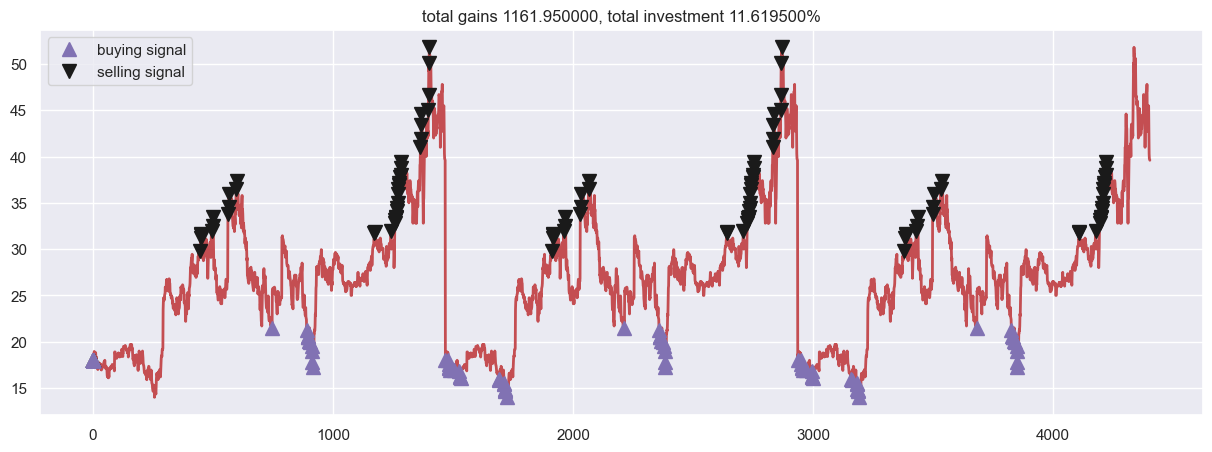

In [23]:
close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()

In [30]:
!pip install -U vnstock
!pip install plotly

   ---------------------------------------- 0.0/15.6 MB ? eta -:--:--
   ---------------------------------------- 0.1/15.6 MB 1.7 MB/s eta 0:00:10
    --------------------------------------- 0.2/15.6 MB 2.4 MB/s eta 0:00:07
   - -------------------------------------- 0.5/15.6 MB 4.3 MB/s eta 0:00:04
   -- ------------------------------------- 1.1/15.6 MB 6.2 MB/s eta 0:00:03
   ----- ---------------------------------- 2.3/15.6 MB 9.6 MB/s eta 0:00:02
   -------- ------------------------------- 3.3/15.6 MB 11.0 MB/s eta 0:00:02
   ---------- ----------------------------- 4.1/15.6 MB 12.6 MB/s eta 0:00:01
   ---------- ----------------------------- 4.1/15.6 MB 12.6 MB/s eta 0:00:01
   ------------------ --------------------- 7.1/15.6 MB 16.2 MB/s eta 0:00:01
   --------------------- ------------------ 8.4/15.6 MB 17.3 MB/s eta 0:00:01
   ------------------------ --------------- 9.8/15.6 MB 18.4 MB/s eta 0:00:01
   ---------------------------- ----------- 11.0/15.6 MB 24.2 MB/s eta 0:00:0

In [28]:
import plotly
import vnstock

df =  stock_historical_data(symbol='GMD', 
                            start_date="2021-01-01", 
                            end_date='2022-02-25', resolution='1D', type='stock', beautify=True, decor=False, source='DNSE')
print(df)

ModuleNotFoundError: No module named 'plotly'